# MODELO DE REGRESIÓN USANDO H2O

## Realizado por Pablo Sánchez Cabrera

In [4]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator 
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

In [5]:
# 0. Inicio del cluster
h2o.init(nthreads = -1,max_mem_size = "4g")
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,1 min 44 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,4 months and 12 days
H2O_cluster_name:,H2O_from_python_p_san_dbmua4
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


# 1. Cargar datos

In [9]:
data = pd.read_csv("../data/BostonHousing.csv")
data = data.drop("CAT. MEDV", axis=1) # eliminamos columna
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


`Conversión a h2o`

In [10]:
data = h2o.H2OFrame(data)  # conversión a data.frame de H2O

# identificación de las variables factor (variables categóricas)
data['CHAS'] = data['CHAS'].asfactor()
data['RAD'] = data['RAD'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Nota: Habitualmente, el preprocesado de datos será hecho con Pandas pero también puede hacerse directamente en H2O.

Para conocer la sintaxis de H2O en la manipulación de datos ver el siguiente enlace: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging.html es aconsejable manipular datos con H2O


# 2. Identificación de variables y Partición de la muestra (entremiento y test)

In [11]:
x = data.columns[:-1] #variables dependientes
y = 'MEDV' #target

seed=123
particiones = 10

train, test = data.split_frame(ratios=[.8], seed=seed) # división de la muestra (muestra test 20%)

# muestra entrenamiento y test
print(f"muestra train: {train.shape}")
print(f"muestra test: {test.shape}")

muestra train: (396, 13)
muestra test: (110, 13)


# 3. Modelización

## 3.1 Modelos básicos

## 3.1.1 Modelo GLM - Regresión lineal

In [12]:
# Definición del modelo y entrenenamiento 
glm = H2OGeneralizedLinearEstimator(alpha=.25, seed=seed, nfolds=particiones) # parámetro de regularización
glm.train(x=x, y=y, training_frame=train, validation_frame=test)
# glm.summary # resumen del modelo

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1754730853905_1


GLM Model: summary
    family    link      regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.25, lambda = 0.02651 )  21                            21                             1                       py_4_sid_ae4f

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 22.595663932714977
RMSE: 4.753489658420956
MAE: 3.2297535989903063
RMSLE: NaN
Mean Residual Deviance: 22.595663932714977
R^2: 0.7216495912937955
Null degrees of freedom: 395
Residual degrees of freedom: 374
Null deviance: 32146.11021749827
Residual deviance: 8947.882917355131
AIC: 2404.431496786635

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 20.76520804462942
RMSE: 4.55688578358394
MAE: 3.4802125253085547
RMSLE: 0.23770798558708742
Mean Residual Deviance: 20.76520804462942
R^2: 0.7830689273178059
Null degrees of freedom: 109
Residual degrees of freedom: 88
Null deviance: 10581.490534399902
Residual deviance: 2284.1728849092365
AIC: 691.8271558691062

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 26.02401436029006
RMSE: 5.101373771866757
MAE: 3.4337475079956614
RMSLE: NaN
Mean Residual Deviance: 26.02401436029006
R^2: 0.6794165882917551
Null degrees of freedom: 395
Residual degrees of freedom: 374
Null deviance: 32425.11764935668
Residual deviance: 10305.509686674864
AIC: 2460.371135726333

Cross-Validation Metrics Summary: 
                        mean      sd        cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  --------  --------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
aic                     284.002   33.4503   312.61        292.945       270.095       224.687       316.32        258.151       239.86        309.511       306.442       309.394
loglikelihood           0         0         0             0             0             0             0             0             0             0             0             0
mae                     3.42203   0.540868  3.99783       2.86858       3.06873       2.81251       4.10647       3.73313       2.90888       3.18122       3.3426        4.20035
mean_residual_deviance  26.0562   10.4142   28.857        12.5597       19.2872       18.6568       38.3183       36.2678       14.8945       20.4487       28.8791       42.3931
mse                     26.0562   10.4142   28.857        12.5597       19.2872       18.6568       38.3183       36.2678       14.8945       20.4487       28.8791       42.3931
null_deviance           3242.51   1200.45   2266.42       2556.29       4127.94       1472.91       5688.76       3346.28       2826.32       2589.99       3290.64       4259.57
r2                      0.659555  0.112525  0.441604      0.755266      0.817749      0.601914      0.657795      0.641777      0.813287      0.635325      0.631384      0.599451
residual_deviance       1030.55   427.02    1240.85       577.746       752.201       578.362       1609.37       1196.84       521.306       920.191       1212.92       1695.72
rmse                    5.01057   1.02765   5.37187       3.54397       4.39172       4.31936       6.19017       6.02228       3.85934       4.52202       5.37393       6.51099
rmsle                   0.247294  0.108677  nan           0.202184      0.165559      0.175814      0.50067       0.288111      0.145324      0.249103      0.202616      0.296261

Scoring History: 
   

`Explicación del modelo`

Importancia de las variables y Bondad de ajuste

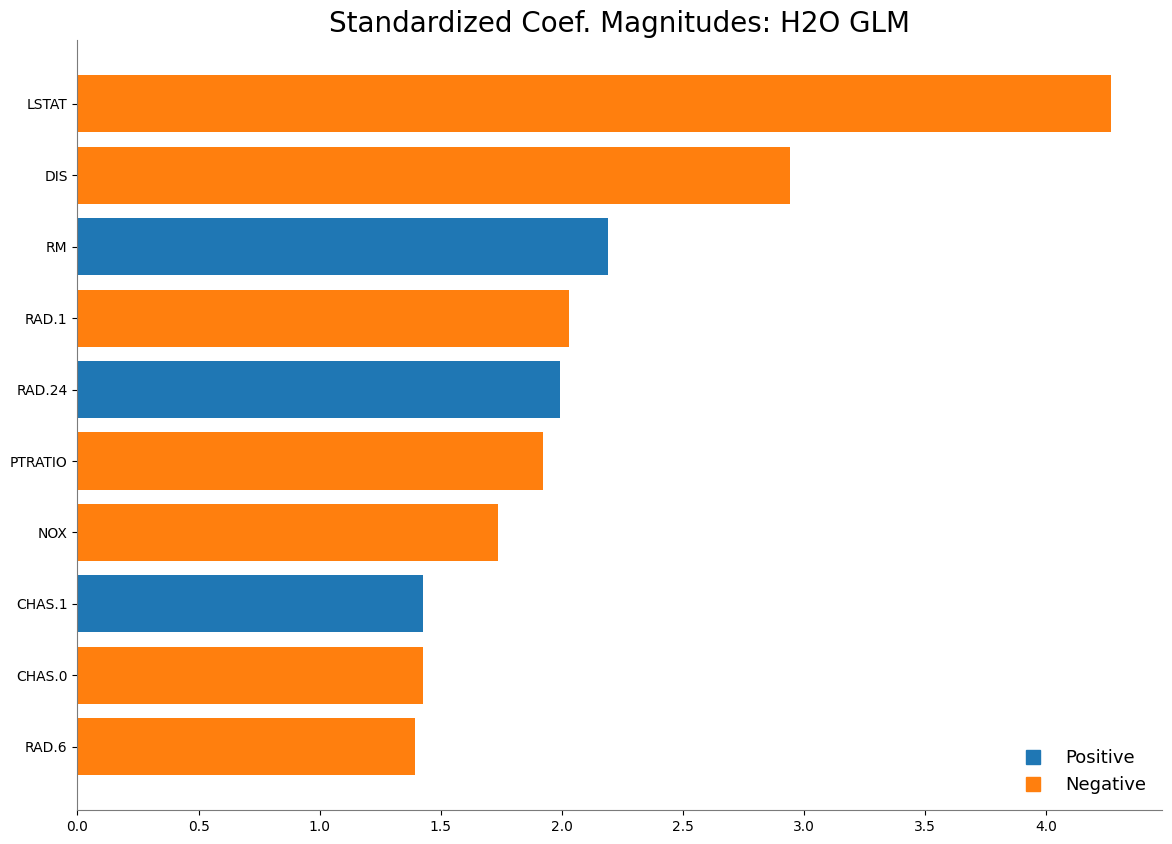

In [13]:
#coeficientes del modelo
glm_coef=glm._model_json['output']['coefficients_table'].as_data_frame() # data.frame de pandas para 

# gráfico coeficientes estandarizados - 10 primeras variables 
glm.std_coef_plot(num_of_features=10) # Para los modelos GLM, H2O permite visualizar los coeficientes estandarizados 

Se presentan los resultados para diferentes métricas y muestras:

In [14]:
print('Entrenamiento')
print('------------------')
print('RMSE:', round(glm.rmse(),5))
print('R-square:', round(glm.r2(), 5))
print('')
print('Cross-Validation')
print('------------------')
print('RMSE:', round(glm.rmse(xval=True),5))
print('R-square:', round(glm.r2(xval=True), 5))
print('')
print('Test')
print('------------------')
print('RMSE:', round(glm.rmse(valid=True),5))
print('R-square:', round(glm.r2(valid=True), 5))

Entrenamiento
------------------
RMSE: 4.75349
R-square: 0.72165

Cross-Validation
------------------
RMSE: 5.10137
R-square: 0.67942

Test
------------------
RMSE: 4.55689
R-square: 0.78307


`Predicciones del modelo`

In [15]:
pred = glm.predict(test)
pred_glm = pred.as_data_frame(use_pandas=True, use_multi_thread=False) #conversión a data.frame de pandas
pred_glm.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\p_san\anaconda3\envs\h2o_env\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,predict
0,9.919488
1,18.025360
2,19.463051
3,15.104538
4,22.798738


## 3.2 Modelos con hiperparámetros

### 3.2.1 Random Forest

In [16]:
hiperparametros = {
    "ntrees":[5, 6, 7, 8, 9, 10], "max_depth": [4, 6, 8]
} # diccionario con los hiperparámetros

# Definición del modelo
grid_rf = H2OGridSearch(
    model=H2ORandomForestEstimator, grid_id = "grid_glm", hyper_params=hiperparametros
)

# Entrenamiento del modelo
grid_rf.train(
    x=x, y=y, training_frame=train, validation_frame=test, sample_rate=0.5, nfolds=particiones, seed=seed,
)

drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,max_depth,ntrees,model_ids,residual_deviance
,8.0,10.0,grid_glm_model_18,13.4084528
,8.0,9.0,grid_glm_model_15,13.4882756
,6.0,10.0,grid_glm_model_17,13.6098928
,8.0,8.0,grid_glm_model_12,13.6401112
,6.0,9.0,grid_glm_model_14,13.7244744
,6.0,8.0,grid_glm_model_11,13.8577731
,8.0,7.0,grid_glm_model_9,13.9888315
,6.0,7.0,grid_glm_model_8,14.1270046
,8.0,6.0,grid_glm_model_6,16.0722306
,8.0,5.0,grid_glm_model_3,16.1129699


Presentación de todos los modelos

In [17]:
rf_grid_all = grid_rf.get_grid(sort_by='r2', decreasing=True) # métrica según cv
rf_grid_all

,max_depth,ntrees,model_ids,r2
,8.0,10.0,grid_glm_model_18,0.8348246
,8.0,9.0,grid_glm_model_15,0.8338413
,6.0,10.0,grid_glm_model_17,0.8323431
,8.0,8.0,grid_glm_model_12,0.8319708
,6.0,9.0,grid_glm_model_14,0.8309316
,6.0,8.0,grid_glm_model_11,0.8292895
,8.0,7.0,grid_glm_model_9,0.8276750
,6.0,7.0,grid_glm_model_8,0.8259729
,8.0,6.0,grid_glm_model_6,0.8020102
,8.0,5.0,grid_glm_model_3,0.8015083


`Mejor modelo, explicación y bondad de ajuste`

In [18]:
rf_best = rf_grid_all.models['model_ids'=='grid_glm_model_2'] # utilizando el id del modelo

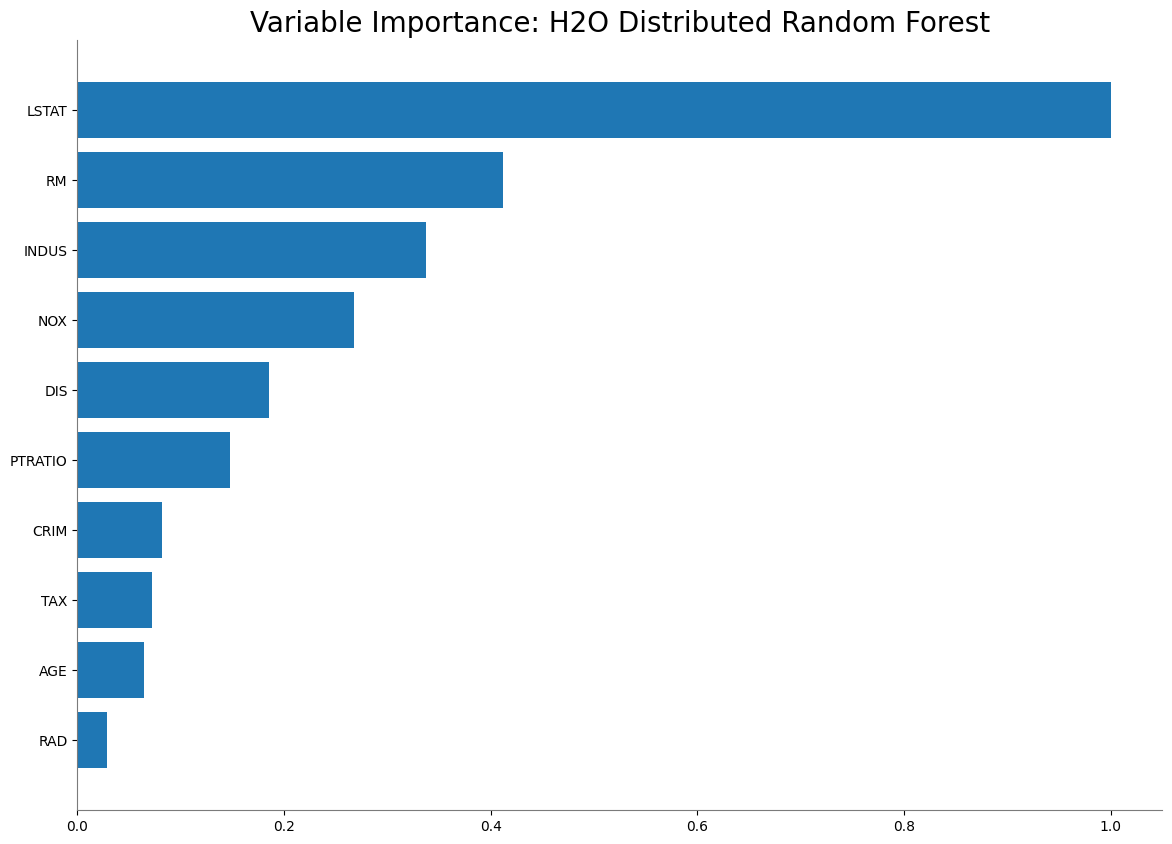

<Figure size 640x480 with 0 Axes>

In [19]:
rf_best.varimp_plot()
plt.show()

In [20]:
# Bondad de ajuste

print('Entrenamiento')
print('------------------')
print('RMSE:', round(rf_best.rmse(),5))
print('R-square:', round(rf_best.r2(), 5))
print('')
print('Cross-Validation')
print('------------------')
print('RMSE:', round(rf_best.rmse(xval=True),5))
print('R-square:', round(rf_best.r2(xval=True), 5))
print('')
print('Test')
print('------------------')
print('RMSE:', round(rf_best.rmse(valid=True),5))
print('R-square:', round(rf_best.r2(valid=True), 5))

Entrenamiento
------------------
RMSE: 3.58369
R-square: 0.84179

Cross-Validation
------------------
RMSE: 3.66176
R-square: 0.83482

Test
------------------
RMSE: 3.32398
R-square: 0.88457


`Predicciones del modelo`

In [21]:
pred = rf_best.predict(test)
pred_rf = pred.as_data_frame() #conversión a data.frame de pandas
pred_rf.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\p_san\anaconda3\envs\h2o_env\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,predict
0,18.910645
1,19.782387
2,18.440099
3,16.503801
4,21.563737


### 3.2.2 Gradient Boosting

In [22]:
# hiperparámetros del modelo
hiperparametros= {
    'learn_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 9],
    'sample_rate': [0.8, 1.0],
    'col_sample_rate': [0.2, 0.5, 1.0]
}

grid_adicional = {'strategy': 'RandomDiscrete', 'max_models': 10, 'seed': seed}  # mejora de performance

# Definición del modelo y entrenamamiento
gbm_grid = H2OGridSearch(
    model=H2OGradientBoostingEstimator, grid_id='gbm_grid', hyper_params=hiperparametros, search_criteria=grid_adicional
)
gbm_grid.train(x=x, y=y,
                training_frame=train,
                validation_frame=test,
                ntrees=100,
                nfolds=particiones,
                seed=seed)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,residual_deviance
,0.2,0.1,3.0,0.8,gbm_grid_model_2,11.0793843
,1.0,0.1,5.0,1.0,gbm_grid_model_4,11.4759157
,1.0,0.1,9.0,0.8,gbm_grid_model_1,11.7940187
,0.5,0.05,5.0,0.8,gbm_grid_model_8,12.0662862
,1.0,0.1,5.0,0.8,gbm_grid_model_7,12.1003483
,1.0,0.05,9.0,1.0,gbm_grid_model_3,12.2740078
,1.0,0.1,3.0,0.8,gbm_grid_model_5,12.4934960
,0.5,0.01,9.0,0.8,gbm_grid_model_10,25.9502274
,1.0,0.01,3.0,0.8,gbm_grid_model_6,28.0040558
,0.2,0.01,3.0,1.0,gbm_grid_model_9,36.9911745


Presentación de todos los modelos

In [23]:
gbm_grid_all = gbm_grid.get_grid(sort_by='r2', decreasing=True) #métrica según cv
gbm_grid_all

,col_sample_rate,learn_rate,max_depth,sample_rate,model_ids,r2
,0.2,0.1,3.0,0.8,gbm_grid_model_2,0.8635158
,1.0,0.1,5.0,1.0,gbm_grid_model_4,0.8586310
,1.0,0.1,9.0,0.8,gbm_grid_model_1,0.8547124
,0.5,0.05,5.0,0.8,gbm_grid_model_8,0.8513584
,1.0,0.1,5.0,0.8,gbm_grid_model_7,0.8509388
,1.0,0.05,9.0,1.0,gbm_grid_model_3,0.8487995
,1.0,0.1,3.0,0.8,gbm_grid_model_5,0.8460957
,0.5,0.01,9.0,0.8,gbm_grid_model_10,0.6803256
,1.0,0.01,3.0,0.8,gbm_grid_model_6,0.6550249
,0.2,0.01,3.0,1.0,gbm_grid_model_9,0.5443148


`Mejor modelo, explicación y bondad de ajuste`

In [24]:
gbm_best = gbm_grid_all.models['model_ids'=='gbm_grid_model_2'] #utilizando el nombre del modelo

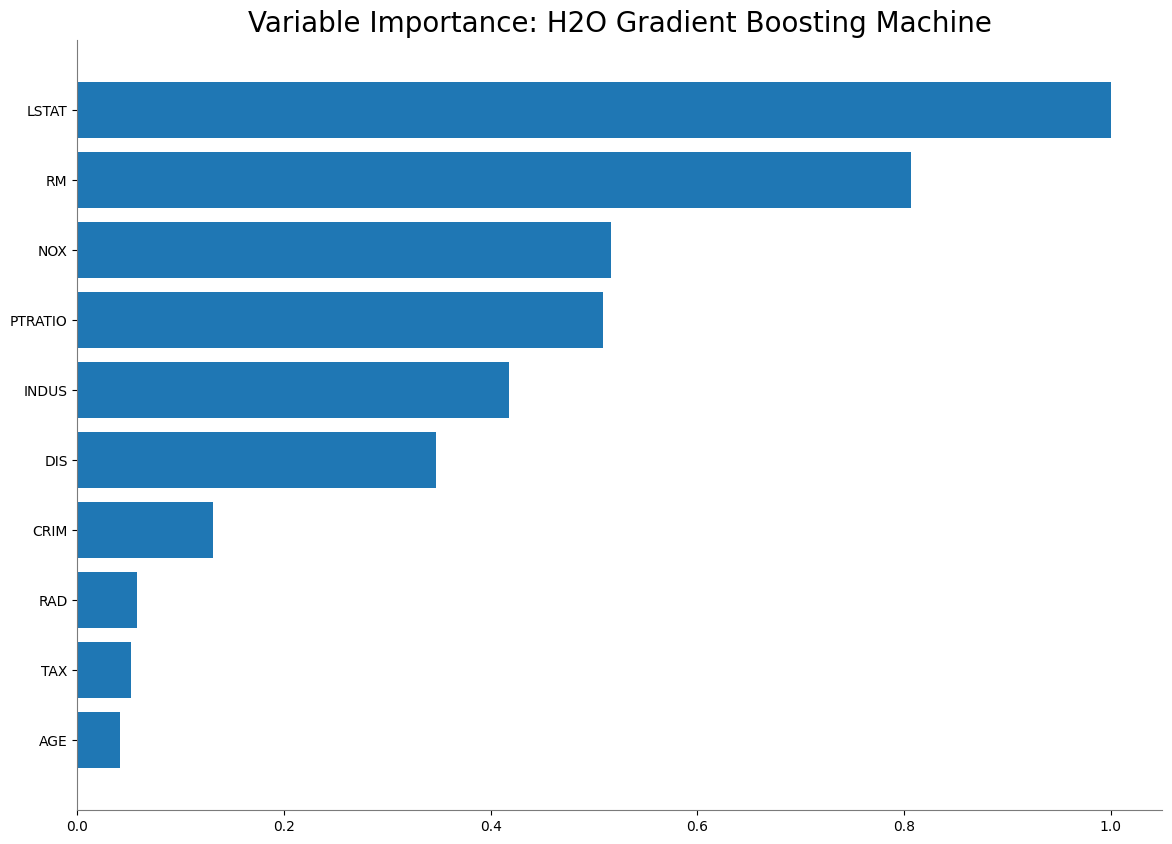

<Figure size 640x480 with 0 Axes>

In [25]:
gbm_best.varimp_plot()
plt.show()

In [26]:
# Bondad de ajuste

print('Entrenamiento')
print('------------------')
print('RMSE:', round(gbm_best.rmse(),5))
print('R-square:', round(gbm_best.r2(), 5))
print('')
print('Cross-Validation')
print('------------------')
print('RMSE:', round(gbm_best.rmse(xval=True),5))
print('R-square:', round(gbm_best.r2(xval=True), 5))
print('')
print('Test')
print('------------------')
print('RMSE:', round(gbm_best.rmse(valid=True),5))
print('R-square:', round(gbm_best.r2(valid=True), 5))

Entrenamiento
------------------
RMSE: 2.17882
R-square: 0.94152

Cross-Validation
------------------
RMSE: 3.32857
R-square: 0.86352

Test
------------------
RMSE: 2.99636
R-square: 0.90621


`Predicciones del modelo`

In [27]:
pred = gbm_best.predict(test)
pred_gbm = pred.as_data_frame() #conversión a data.frame de pandas
pred_gbm.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


C:\Users\p_san\anaconda3\envs\h2o_env\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,predict
0,17.665878
1,19.019804
2,17.726411
3,15.553153
4,22.809244


# 4. Análisis de los resultados 

C:\Users\p_san\anaconda3\envs\h2o_env\lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


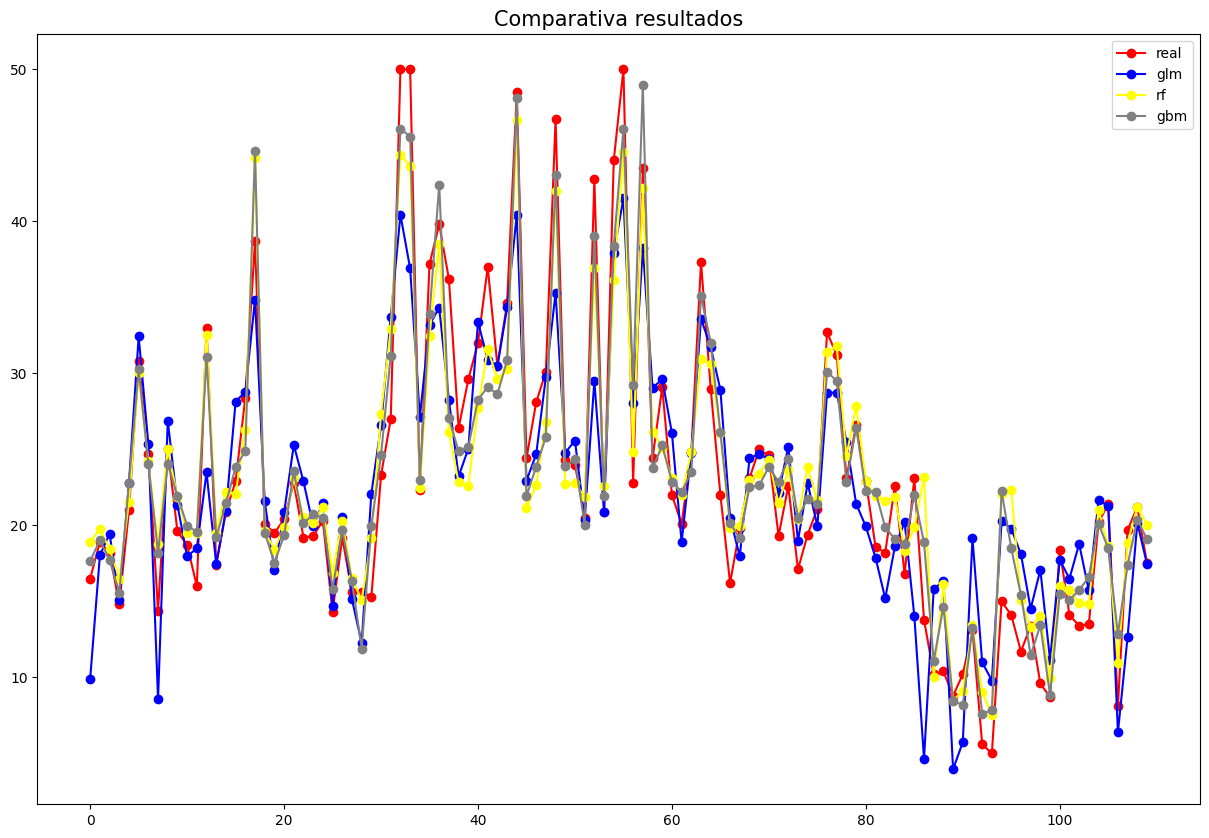

In [28]:
# Datos reales vs ajustados
target_df = test['MEDV'].as_data_frame() # datos de test conversión a data.frame de pandas (variable target)

plt.figure(figsize=(15,10))
plt.plot(target_df, color='red', label='real', marker='o'), plt.legend(loc='upper right')
plt.plot(pred_glm,color='blue', label='glm', marker='o'), plt.legend(loc='upper right')
plt.plot(pred_rf,color='yellow', label='rf', marker='o'), plt.legend(loc='upper right')
plt.plot(pred_gbm,color='gray', label='gbm', marker='o'), plt.legend(loc='upper right')
plt.title('Comparativa resultados', fontsize=15)
plt.show() 

# 5. Guardado del modelo

Vamos a guardar tanto el modelo lineal como el gradient boosting. Se crea una función

In [29]:
ruta_actual = os.getcwd()
print(ruta_actual)

C:\Users\p_san\OneDrive\Escritorio\h2o-project\notebook


In [33]:
def save_h2o_model(path, folder_name, model):
    actual_path = os.getcwd()
    model_path = actual_path + "/" + path + "/" + folder_name
    if not os.path.exists(model_path):
        os.makedirs(model_path)
        print(f"Directorio {model_path} creado para guardar el artefacto del modelo")

    saved_path = h2o.save_model(model=model, path=model_path, force=True)
    print(f"Modelo guardado en: {saved_path}")

`Modelo lineal`

In [36]:
save_h2o_model("../artifact", "modelo_lineal", glm)

Directorio C:\Users\p_san\OneDrive\Escritorio\h2o-project\notebook/../artifact/modelo_lineal creado para guardar el artefacto del modelo
Modelo guardado en: C:\Users\p_san\OneDrive\Escritorio\h2o-project\artifact\modelo_lineal\GLM_model_python_1754730853905_1


`Gradient Boosting`

In [37]:
save_h2o_model("../artifact", "gbm", gbm_best)

Directorio C:\Users\p_san\OneDrive\Escritorio\h2o-project\notebook/../artifact/gbm creado para guardar el artefacto del modelo
Modelo guardado en: C:\Users\p_san\OneDrive\Escritorio\h2o-project\artifact\gbm\gbm_grid_model_2
